In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [2]:
#standard imports
import time
import numpy as np
import h5py


In [3]:
#We're not using the GPU here, so we set the 
#"CUDA_VISIBLE_DEVICES" environment variable to -1
#which tells tensorflow to only use the CPU

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
import tensorflow as tf

## Gradient Descent

In [4]:
#let's define a model which "believes" that the output data
#is scalar power of a scalar input, e.g. :
#      y ~ x^p

#defining the scalar input data variable 
batch_size = 200
x = tf.get_variable('x', shape=(batch_size,), dtype=tf.float32)

#define the scalar power variable
initial_power = tf.zeros(shape=())
power = tf.get_variable('pow', initializer=initial_power, dtype=tf.float32)

#define the model
model = x**power

#the output data needs a variable too
y = tf.get_variable('y', shape=(batch_size,), dtype=tf.float32)

In [8]:
#the error rate of the model is mean L2 distance across 
#the batch of data

loss = tf.reduce_mean((model - y)**2)

In [174]:
#now, our goal is to use gradient descent to 
#figure out the parameter of our model -- namely, the power variable
grad = tf.gradients(loss, power)[0]

In [5]:
#Let's fit (optimize) the model.   
#to do that we'll have to first of course define a tensorflow session

sess = tf.Session()

In [12]:
#... and initialize the power variable
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [184]:
#ok ... so let's test the case where the true input-output relationship
#is x --> x^2
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2

In [185]:
#OK
initial_guess = 0
assign_op = tf.assign(power, initial_guess)
sess.run(assign_op)

gradval = sess.run(grad, feed_dict={x: xval, y: yval})


In [186]:
gradval

-1.5306325

In [187]:
#ok so this is telling us to do:

new_guess = initial_guess + -1 * (gradval)
print(new_guess)

1.53063249588


In [188]:
#ok so let's assign the new guess to the power variable
assign_op = tf.assign(power, new_guess)
sess.run(assign_op)

#... and get the gradient again
gradval = sess.run(grad, feed_dict={x: xval, y: yval})

gradval

-0.56193405

In [189]:
new_guess = new_guess + -1 * (gradval)
print(new_guess)

2.09256654978


In [190]:
#... and one more time ...
assign_op = tf.assign(power, new_guess)
sess.run(assign_op)

#... get the gradient again
gradval = sess.run(grad, feed_dict={x: xval, y: yval})
print('gradient: %.3f', gradval)

#... do the update
new_guess = new_guess + -1 * (gradval)
print('power: %.3f', new_guess)

#ok so we're hovering back and forth around guess of 2.... which is right!

('gradient: %.3f', 0.17790559)
('power: %.3f', 1.9146609604358673)


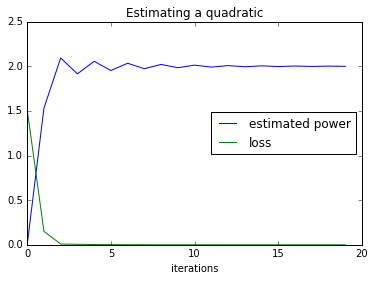

In [211]:
#OK let's do this in a real loop and keep track of useful stuff along the way
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2

#start the guess off at 0 again
assign_op = tf.assign(power, 0)
sess.run(assign_op)

#let's keep track of the guess along the way
powers = []

#and the loss, which should go down
losses = []

#and the grads just for luck
grads = []

#let's iterate the gradient descent process 20 timesteps
num_iterations = 20

#for each timestep ...
for i in range(num_iterations):
    
    #... get the current derivative (grad), the current guess of "power"
    #and the loss, given the input and output training data (xval & yval)
    output = sess.run({'grad': grad, 
                       'power': power,
                       'loss': loss}, 
                      feed_dict={x: xval, y: yval})
    current_power = output['power']
    current_loss = output['loss']
    gradval = output['grad']
    
    #... keep track of interesting stuff along the way
    powers.append(current_power)
    grads.append(gradval)
    losses.append(current_loss)
    
    #... now do the gradient descent step
    new_power = current_power - gradval
    
    #... and actually update the value of the power variable
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
    #and then, the loop runs again
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.xlabel('iterations')
plt.legend(loc='center right')
plt.title('Estimating a quadratic')

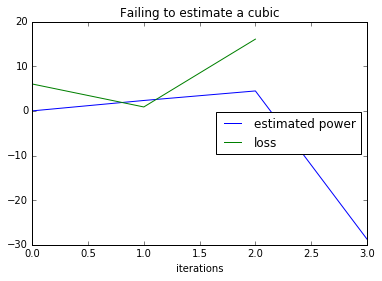

In [212]:
##ok now let's try that again except where y ~ x^3

#all we need to do is change the data
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3

#The rest  of the code remains the same
assign_op = tf.assign(power, 0)
sess.run(assign_op)

powers = []
losses = []
grads = []

num_iterations = 20
for i in range(num_iterations):    
    output = sess.run({'grad': grad, 
                       'power': power,
                       'loss': loss}, 
                      feed_dict={x: xval, y: yval})
    current_power = output['power']
    current_loss = output['loss']
    gradval = output['grad']
    
    powers.append(current_power)
    grads.append(gradval)
    losses.append(current_loss)
    
    new_power = current_power - gradval
    
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.xlabel('iterations')
plt.legend(loc='center right')
plt.title('Failing to estimate a cubic')
    
#wait ... this did *not* work.  why? 

In [193]:
#whoa ... the loss must have diverged to infinity (or close) really early
losses
#why? 

[6.0235572,
 0.87862968,
 16.070698,
 inf,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [197]:
#let's look at the gradients
grads
#hm.  the gradient was getting big at the end. 

[-2.3299172,
 -2.1364195,
 33.202091,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [198]:
#after all, the taylor series only works in the close-to-the-value limit. 
#we must have been been taking too big steps.  
#how do we fix this? 

In [293]:
def gradient_descent(loss, 
                     target,
                     initial_guess,
                     learning_rate,
                     training_data,
                     num_iterations):
    
    #assign initial value to the garge
    assign_op = tf.assign(target, initial_guess)
    sess.run(assign_op)

    grad = tf.gradients(loss, target)
    
    targets = []
    losses = []
    grads = []
    for i in range(num_iterations):
        output = sess.run({'grad': grad, 
                           'target': target,
                           'loss': loss}, 
                          feed_dict=training_data)
        current_value = np.array(output['target'])
        current_loss = output['loss']
        gradval = np.array(output['grad'])
        targets.append(current_value)
        losses.append(current_loss)
        grads.append(gradval)
        
        #just like before except now we scale the gradient update 
        #by the learning rate
        
        new_value = current_value - gradval * learning_rate
        
        print(current_value, new_value)
        assign_op = tf.assign(target, new_value)
        sess.run(assign_op)
        
    return targets, losses, grads
    

In [295]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3
data_dict = {x: xval, y:yval}

powers, losses, grads = gradient_descent(loss=loss,
                                          target=power,
                                          initial_guess=0,
                                          learning_rate=0.1,
                                          training_data=data_dict,
                                          num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title('Estimating a cubic')

#ok -- now the result stably converges!

AttributeError: 'list' object has no attribute 'dtype'

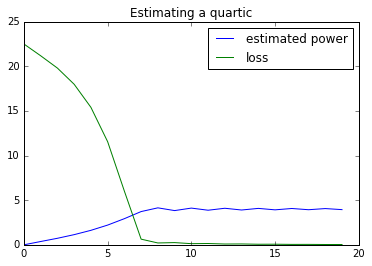

In [267]:
#and also for a higher power .... 
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**4
data_dict = {x: xval, y:yval}

powers, losses, grads = gradient_descent(loss=loss,
                                         target=power,
                                         initial_guess=0,
                                         learning_rate=0.1,
                                         training_data=data_dict,
                                         num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='upper right')
plt.title('Estimating a quartic')

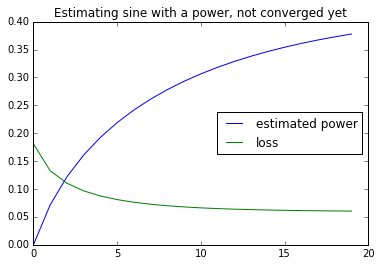

In [268]:
#what about when the data is actually not of the right form?

xval = np.arange(0, 2, .01)
yval = np.sin(xval)


data_dict = {x: xval, y:yval}

powers, losses, grads = gradient_descent(loss=loss,
                                          target=power,
                                          initial_guess=0,
                                          learning_rate=0.1,
                                          training_data=data_dict,
                                          num_iterations=20)
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
plt.title('Estimating sine with a power, not converged yet')

#doesn't look like it's converged yet -- maybe we need to run it longer? 

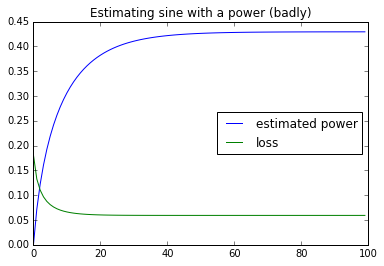

In [269]:
#sine(x) now with more iterations

xval = np.arange(0, 2, .01)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

powers, losses, grads = gradient_descent(loss=loss,
                                        target=power,
                                        initial_guess=0,
                                        learning_rate=0.1,
                                        training_data=data_dict,
                                        num_iterations=100)  #<-- more iterations

plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
plt.title('Estimating sine with a power (badly)')

#ok it's converged but not to a great loss.  This is unsurprising 
#since x^p is a bad model for sine(x)

In [ ]:
#how should we improve? 
#THE MACHINE LEARNING ANSWER:  well, let's have more parameters in our model
#let's write a model using the Taylor series idea more explicitly
#    y ~ sum_i a_i x^i  
#for some coefficients a_i that we have to guess

In [ ]:
approximation_order = 5

coefficients = tf.get_variable('coefficients', 
                        initializer= tf.zeros(shape=(approximation_order,)),
                        dtype=tf.float32)

In [239]:
initializer = tf.global_variables_initializer()
sess.run(initializer)

In [248]:
powervec = tf.range(0, approximation_order, dtype=tf.float32)
x_expanded = tf.expand_dims(x, axis=1)
x_exponentiated = x_expanded**powervec
x_multiplied_by_coefficients = coefficients * x_exponentiated
polynomial_model = tf.reduce_sum(x_multiplied_by_coefficients, axis=1)

polynomial_loss = tf.reduce_mean((polynomial_model - y)**2)

polynomial_grad = tf.gradients(polynomial_loss, coefficients)

In [249]:
xval = np.arange(0, 2, .01)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

sess.run(polynomial_grad, feed_dict=data_dict)

[array([-1.41158855, -1.73249876, -2.45131397, -3.75488901, -6.04951048], dtype=float32)]

In [287]:
xval = np.arange(0, 2, .01)
yval = np.sin(xval)

data_dict = {x: xval, y:yval}

coefvals, losses, grads = gradient_descent(loss=polynomial_loss,
                                        target=coefficients,
                                        initial_guess=np.ones(approximation_order),
                                        learning_rate=0.1,
                                        training_data=data_dict,
                                        num_iterations=20)  #<-- more iterations

TypeError: can't multiply sequence by non-int of type 'float'

In [279]:
grads

[-3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05,
 -3.1372299e-05]

In [93]:
grad2 = tf.gradients(grad, power)[0]

In [96]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3

assign_op = tf.assign(power, 0)
sess.run(assign_op)

sess.run({'grad2': grad2, 'grad': grad, 
                       'power': power,
                       'loss': loss}, 
                      feed_dict={x: xval, y: yval})

{'grad': -2.3299172, 'grad2': 2.9339702, 'loss': 6.0235572, 'power': 0.0}

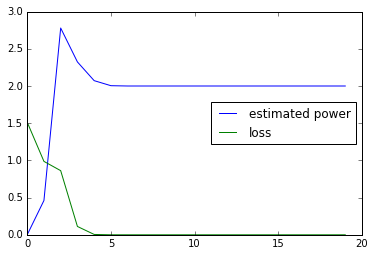

In [106]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**2

assign_op = tf.assign(power, 0)
sess.run(assign_op)

powers = []
losses = []
for i in range(20):
    output = sess.run({'grad': grad,
                       'grad2': grad2,
                       'power': power,
                       'loss': loss}, 
                      feed_dict={x: xval, y: yval})
    current_power = output['power']
    current_loss = output['loss']
    powers.append(current_power)
    losses.append(current_loss)
    gradval = output['grad']
    grad2val = output['grad2']
    new_power = current_power - gradval / grad2val
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
    

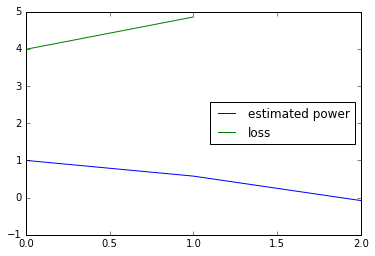

In [149]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3

assign_op = tf.assign(power, 1)
sess.run(assign_op)

powers = []
losses = []

learning_rate = .1
for i in range(20):
    output = sess.run({'grad': grad,
                       'grad2': grad2,
                       'power': power,
                       'loss': loss}, 
                      feed_dict={x: xval, y: yval})
    current_power = output['power']
    current_loss = output['loss']
    powers.append(current_power)
    losses.append(current_loss)
    gradval = output['grad']
    grad2val = output['grad2']
    #print(gradval)
    new_power = current_power - gradval / grad2val * learning_rate
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
    

(76.37957, 113.89825)
(26.377148, 45.202255)
(8.5104542, 19.364319)
(2.3287811, 9.7291889)
(0.40988311, 6.4859095)
(0.022078674, 5.7975049)
(7.5526841e-05, 5.7579708)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)
(8.4851823e-09, 5.7578354)


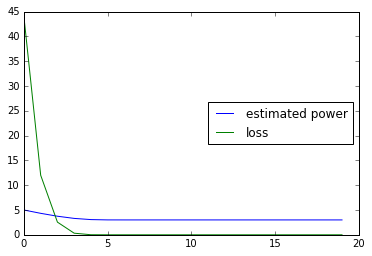

In [172]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3

assign_op = tf.assign(power, 5)
sess.run(assign_op)

powers = []
losses = []

for i in range(20):
    output = sess.run({'grad': grad,
                       'grad2': grad2,
                       'power': power,
                       'loss': loss}, 
                      feed_dict={x: xval, y: yval})
    current_power = output['power']
    current_loss = output['loss']
    powers.append(current_power)
    losses.append(current_loss)
    gradval = output['grad']
    grad2val = output['grad2']
    print(gradval, grad2val)
    new_power = current_power - gradval / np.maximum(grad2val , 1)
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
    

(-2.4045424, 0.37191954)
(-2.2419088, 1.0245801)
(-1.9186679, 1.9111855)
(-1.4565806, 2.9561205)
(-0.95440263, 3.9757071)
(-0.5378381, 4.7720437)
(-0.26791441, 5.2717557)
(-0.12316689, 5.5354853)
(-0.054222323, 5.6601715)
(-0.023381663, 5.7157631)
(-0.0099890754, 5.7398686)
(-0.0042500207, 5.7501926)
(-0.0018046557, 5.75459)
(-0.00076589029, 5.7564583)
(-0.00032527809, 5.7572503)
(-0.00013859692, 5.757586)
(-5.8954749e-05, 5.7577295)
(-2.4656953e-05, 5.7577906)
(-1.0950914e-05, 5.7578154)
(-4.0798345e-06, 5.7578278)


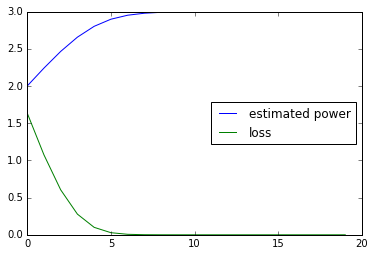

In [160]:
xval = np.arange(0, 2, .01)
yval = np.arange(0, 2, .01)**3

assign_op = tf.assign(power, 2)
sess.run(assign_op)

powers = []
losses = []

learning_rate = .1
for i in range(20):
    output = sess.run({'grad': grad,
                       'grad2': grad2,
                       'power': power,
                       'loss': loss}, 
                      feed_dict={x: xval, y: yval})
    current_power = output['power']
    current_loss = output['loss']
    powers.append(current_power)
    losses.append(current_loss)
    gradval = output['grad']
    grad2val = output['grad2']
    print(gradval, grad2val)
    new_power = current_power - gradval * learning_rate
    assign_op = tf.assign(power, new_power)
    sess.run(assign_op)
    
plt.plot(powers, label='estimated power')
plt.plot(losses, label='loss')
plt.legend(loc='center right')
    